<a href="https://colab.research.google.com/github/Tush-har/Deep_learning_projects/blob/main/Fine_tune_Florence_2_metere_values_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

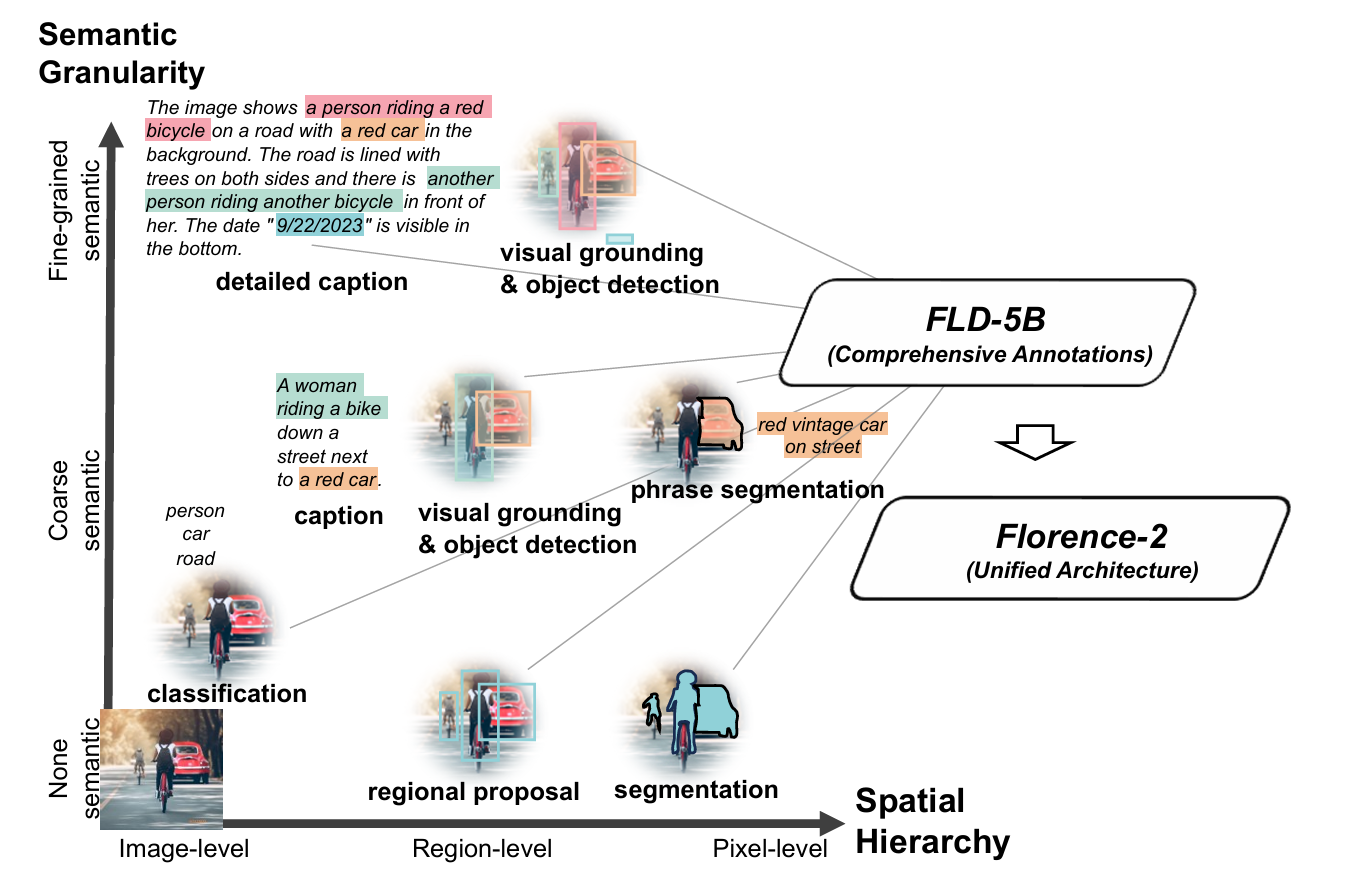

# Fine-tuning Florence-2 to read meter values

let's finetune Florence-2 to read the meter values (OCR task).

In [1]:
!pip install -q datasets flash_attn timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 85.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install transformers==4.51.1 -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1


In [3]:
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [4]:
from datasets import load_dataset
ds = load_dataset('henrik-dra/energy-meter')
print(ds)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/417 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/61.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/138 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 138
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30
    })
})


In [5]:
ds_train=ds['train']
ds_test=ds['test']


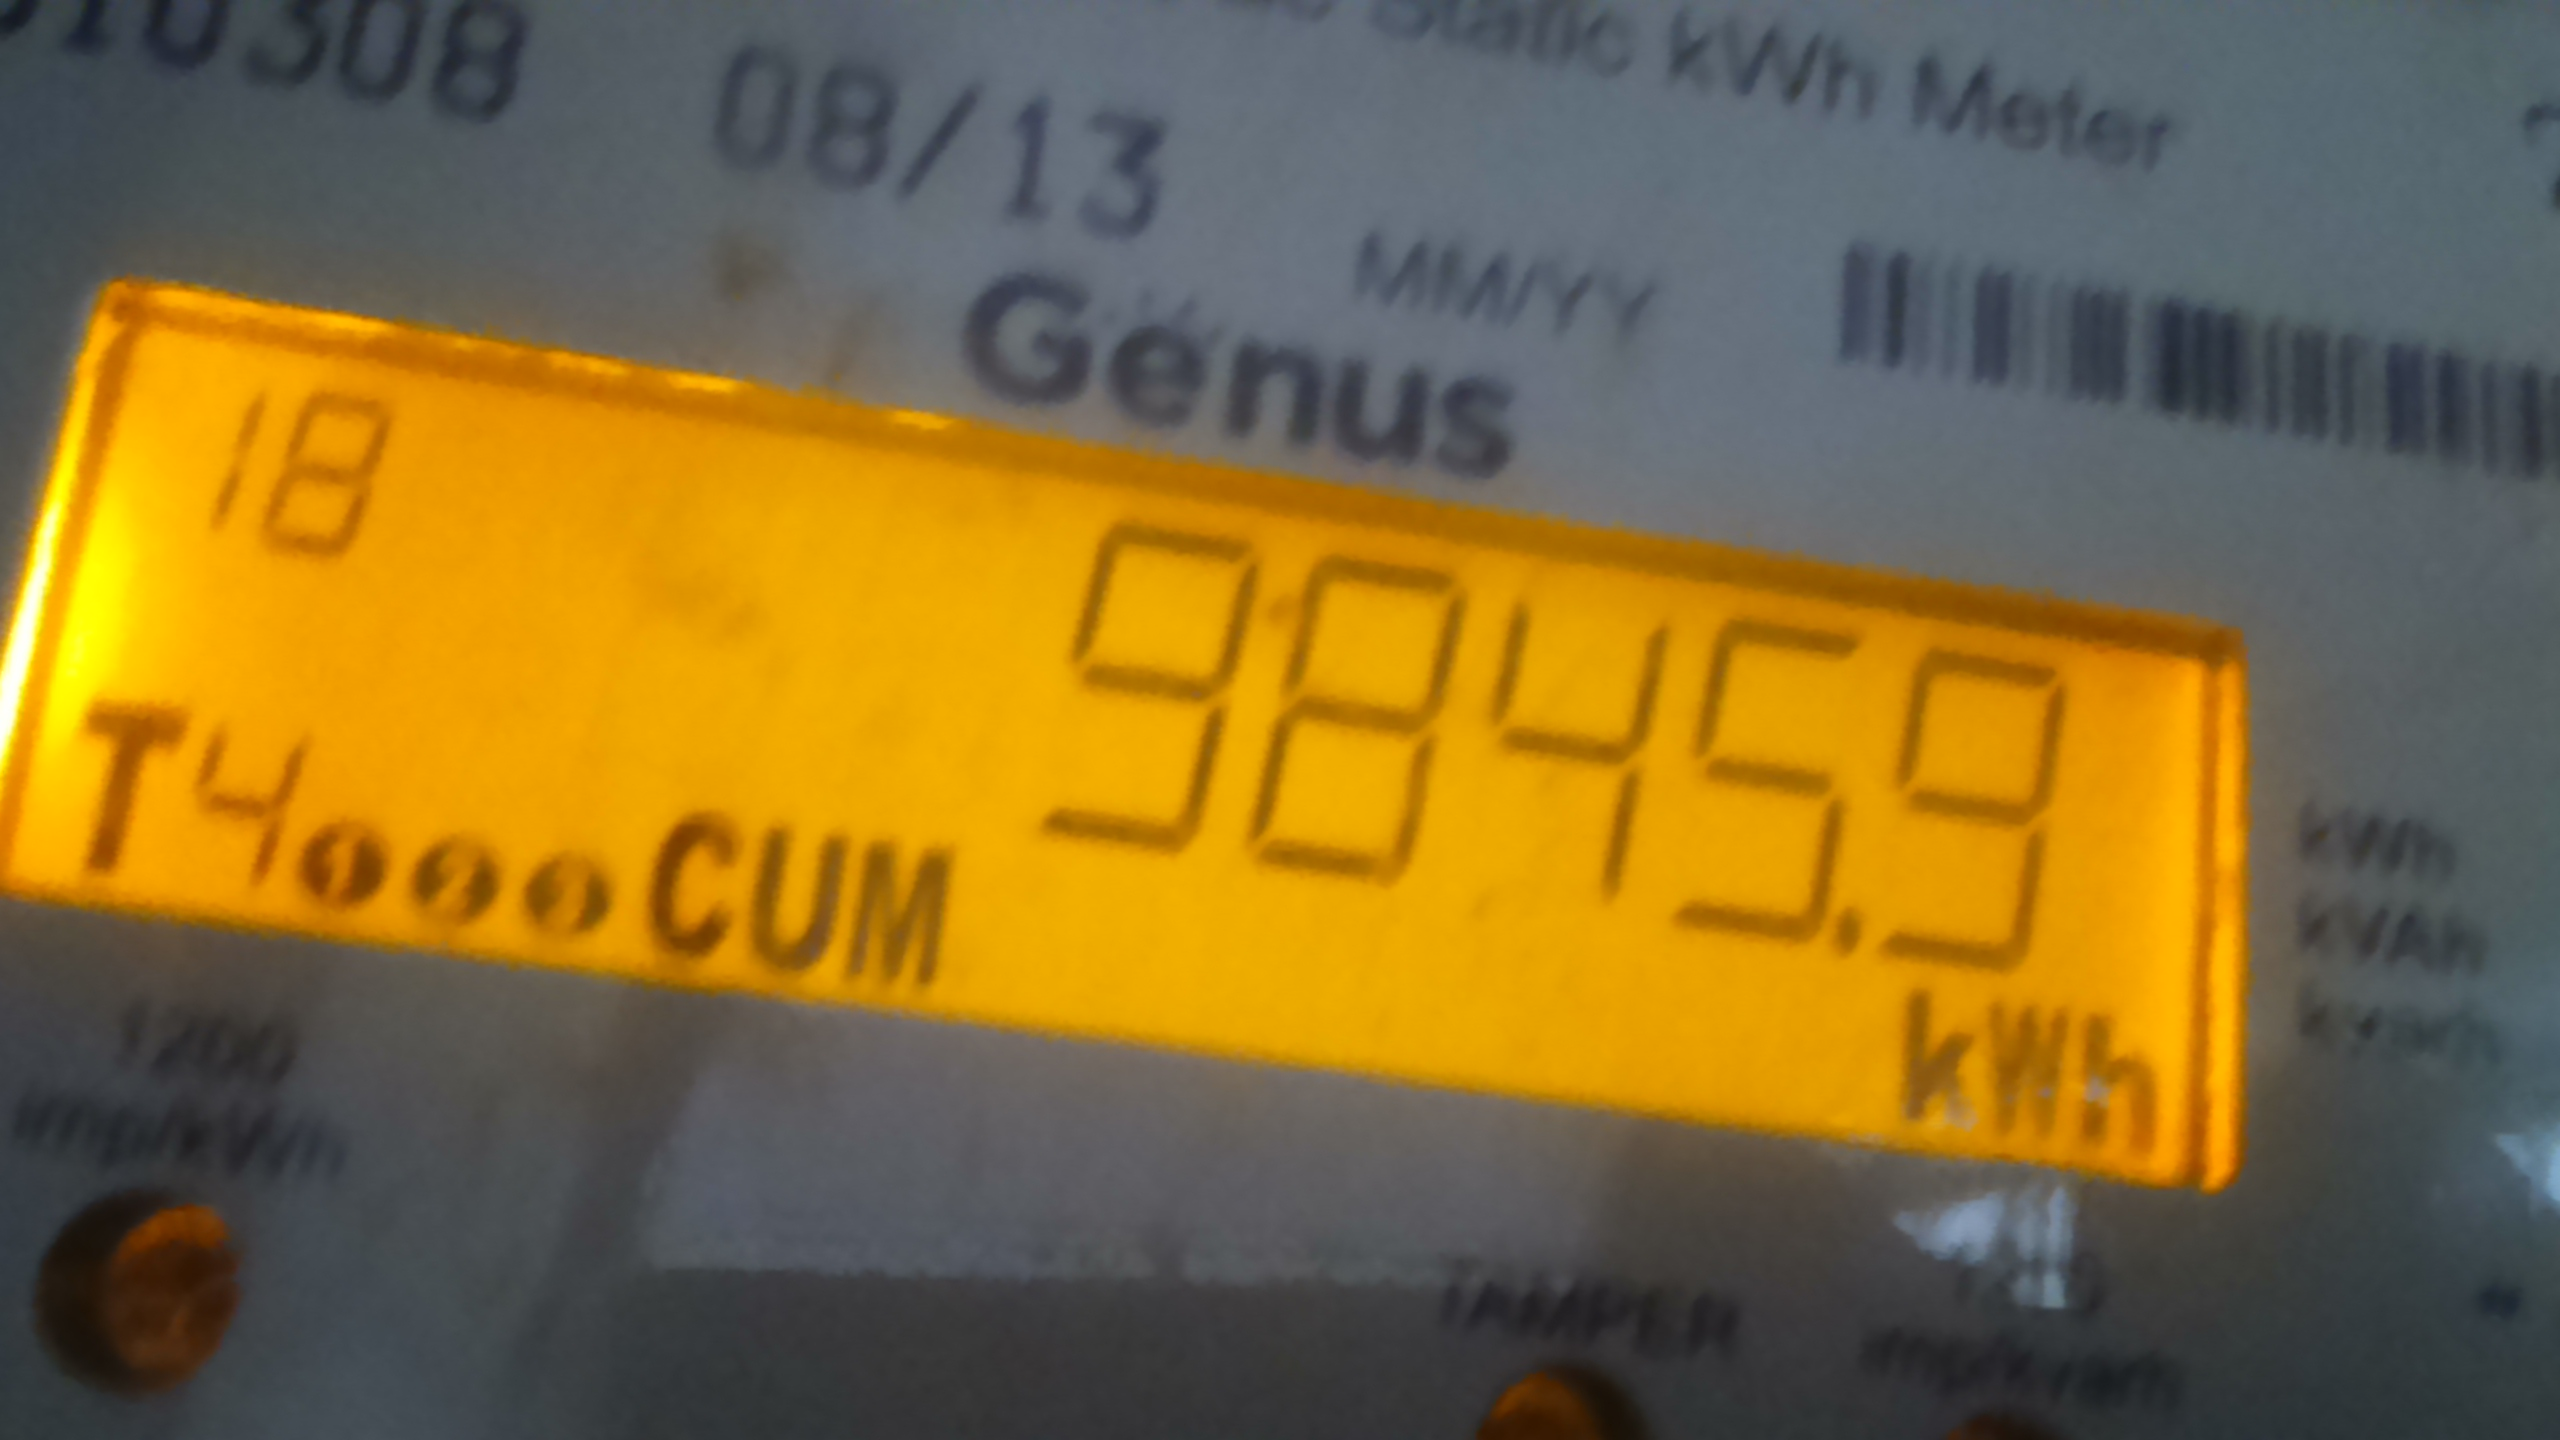

In [6]:
ds_test[0]['image']

In [7]:
ds_test[0]['label']

'9845.9'

We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [8]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)

processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

cuda


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

modeling_florence2.py: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

<unknown>:515: SyntaxWarning: invalid escape sequence '\d'
/root/.cache/huggingface/modules/transformers_modules/microsoft/Florence-2-base-ft/e0b8f375661041228a6431c950adac1a5c539b98/processing_florence2.py:515: SyntaxWarning: invalid escape sequence '\d'
  PATTERN: 'r<time_(\d+)><time_(\d+)>([a-zA-Z0-9 ]+)'


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [9]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': '1.92.7'}


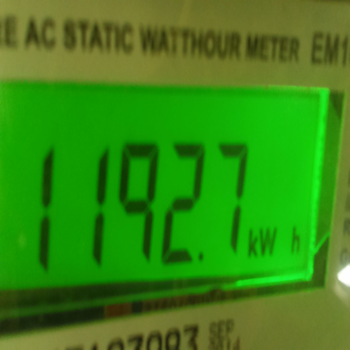

{'DocVQA': 'unanswerable'}


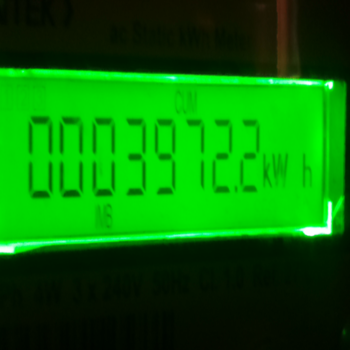

{'DocVQA': 'ok'}


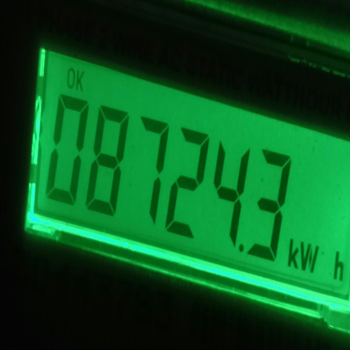

In [12]:
for idx in range(3):
  print(run_example("DocVQA", 'What is the meter values?', ds_train[idx]['image']))
  display(ds_train[idx]['image'].resize([350, 350]))

create a custo dataloader with `<DocVQA> `


In [13]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" +'What is the meter values?'
        answer = example['label']
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, answer, image


In [14]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AutoProcessor, get_scheduler)
from torch.optim import AdamW

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets

train_dataset = DocVQADataset(ds_train)
val_dataset = DocVQADataset(ds_test)

# Create DataLoader
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [15]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [16]:
from huggingface_hub import notebook_login

notebook_login()

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [17]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [18]:
train_model(train_loader, val_loader, model, processor, epochs=2)

Training Epoch 1/2: 100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Average Training Loss: 0.8582573128270282


Validation Epoch 1/2: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


Average Validation Loss: 0.5388444969430566


Training Epoch 2/2: 100%|██████████| 138/138 [01:53<00:00,  1.22it/s]


Average Training Loss: 0.4589095386555013


Validation Epoch 2/2: 100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


Average Validation Loss: 0.4586034642532468


You can push the model like below. You can find the fully fine-tuned DocVQA model [here](https://huggingface.co/HuggingFaceM4/Florence-2-DocVQA). You can find the demo [here](https://huggingface.co/spaces/andito/Florence-2-DocVQA).

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

In [20]:
model.push_to_hub("tusharrr11/Florence-metere_u")
processor.push_to_hub("tusharrr11/Florence-metere_u")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...gjf61xk/model.safetensors:   0%|          |  573kB / 1.08GB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tusharrr11/Florence-metere_u/commit/cf493aa8d23f12d919846e395c807ad1edcecfb4', commit_message='Upload processor', commit_description='', oid='cf493aa8d23f12d919846e395c807ad1edcecfb4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tusharrr11/Florence-metere_u', endpoint='https://huggingface.co', repo_type='model', repo_id='tusharrr11/Florence-metere_u'), pr_revision=None, pr_num=None)

In [21]:
model

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): Depth

In [22]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': '1192.7'}


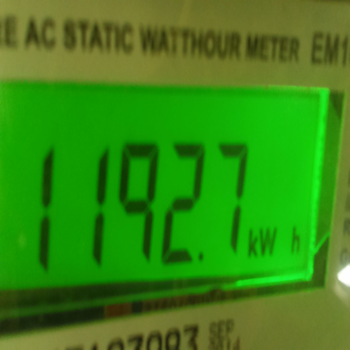

{'DocVQA': '0003972.2'}


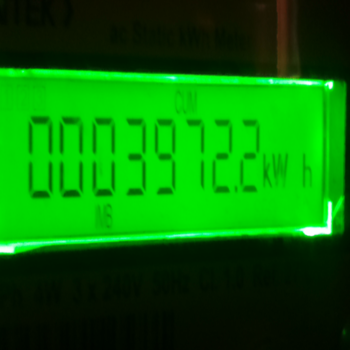

{'DocVQA': '08724.3'}


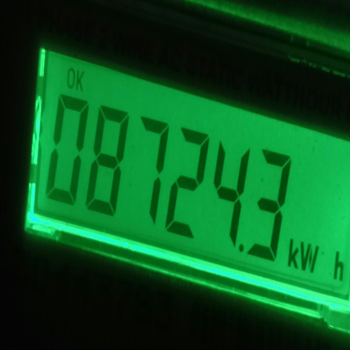

In [23]:
for idx in range(3):
  print(run_example("DocVQA", 'What is the meter values?', ds_train[idx]['image']))
  display(ds_train[idx]['image'].resize([350, 350]))

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import requests

from PIL import Image

prompt = "<DocVQA>"+ 'What is the meter values ?'

image = Image.open("/content/drive/MyDrive/Data_ocr_test/IMG_20250925_124116.jpg")

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<DocVQA>", image_size=(image.width, image.height))

print(parsed_answer)
'"'

{'<DocVQA>': '22.03'}


'"'

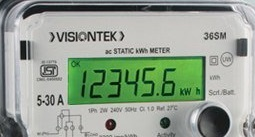

In [ ]:
image

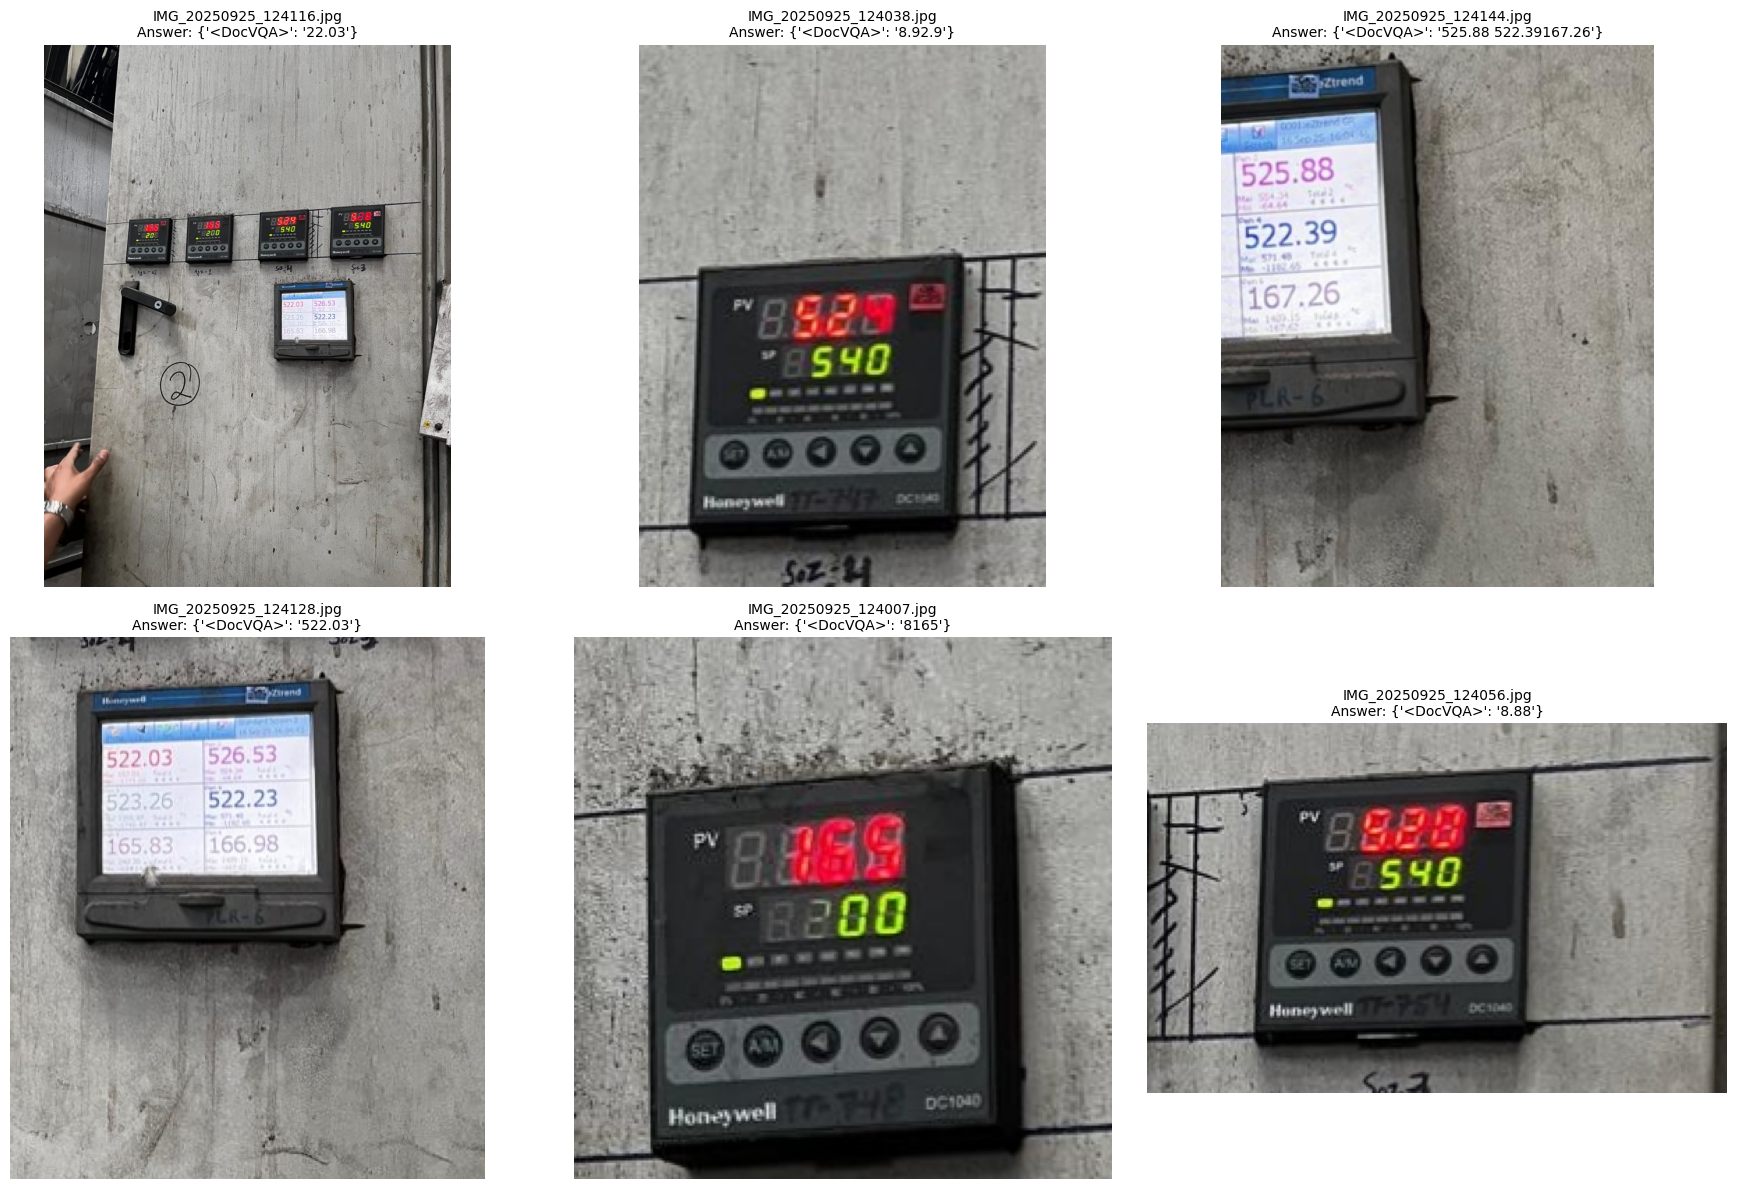

In [31]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 🔹 Path to your folder of images
image_folder = "/content/drive/MyDrive/Data_ocr_test"

# 🔹 Prompt for DocVQA
prompt = "<DocVQA> What is the meter values ?"

# 🔹 Collect all image files in folder
image_files = [os.path.join(image_folder, f)
               for f in os.listdir(image_folder)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

results = []

for img_path in image_files:
    image = Image.open(img_path).convert("RGB")

    # Preprocess
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    # Generate
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=512,
        do_sample=False,
        num_beams=3
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task="<DocVQA>",
        image_size=(image.width, image.height)
    )

    results.append((image, os.path.basename(img_path), parsed_answer))

# 🔹 Display results in a grid
cols = 3
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(18, rows * 6))

for i, (img, fname, answer) in enumerate(results):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{fname}\nAnswer: {answer}", fontsize=10)

plt.tight_layout()
plt.show()
